In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
train_folder = r"C:\Users\ŞeymaÇakmak\Desktop\BİL 468\Project\Project Code\Dataset MAIN\crop_dataset\crop_dataset"
test_folder = r"C:\Users\ŞeymaÇakmak\Desktop\BİL 468\Project\Project Code\Dataset MAIN\test_data\test_data"

train_class_folders = os.listdir(train_folder)

# Dictionary for naming the class types

classes = {0: 'Speed limit (20km/h)',
           1: 'Speed limit (30km/h)',
           2: 'Speed limit (50km/h)',
           3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)',
           5: 'Speed limit (80km/h)',
           6: 'End of speed limit (80km/h)',
           7: 'Speed limit (100km/h)',
           8: 'Speed limit (120km/h)',
           9: 'No passing',
           10: 'No passing veh over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priority road',
           13: 'Yield',
           14: 'Stop',
           15: 'No vehicles',
           16: 'Veh > 3.5 tons prohibited',
           17: 'No entry',
           18: 'General caution',
           19: 'Dangerous curve left',
           20: 'Dangerous curve right',
           21: 'Double curve',
           22: 'Bumpy road',
           23: 'Slippery road',
           24: 'Road narrows on the right',
           25: 'Road work',
           26: 'Traffic signals',
           27: 'Pedestrians',
           28: 'Children crossing',
           29: 'Bicycles crossing',
           30: 'Beware of ice/snow',
           31: 'Wild animals crossing',
           32: 'End speed + passing limits',
           33: 'Turn right ahead',
           34: 'Turn left ahead',
           35: 'Ahead only',
           36: 'Go straight or right',
           37: 'Go straight or left',
           38: 'Keep right',
           39: 'Keep left',
           40: 'Roundabout mandatory',
           41: 'End of no passing',
           42: 'End no passing veh > 3.5 tons'}

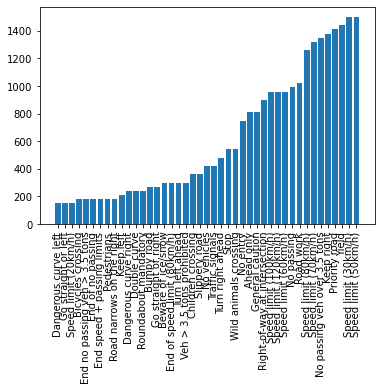

In [3]:
# Get number of instances per class and visualize the data

train_numberOfInstancesPerClass = []
class_names = []

for folder in train_class_folders:
    train_files = os.listdir(train_folder + '/' + folder)
    train_numberOfInstancesPerClass.append(len(train_files))
    class_names.append(classes[int(folder)])

pairs = zip(train_numberOfInstancesPerClass, class_names)
pairs = sorted(pairs)
tuples = zip(*pairs)
train_numberOfInstancesPerClass, class_names = [
    list(tuple) for tuple in tuples]

plt.bar(class_names, train_numberOfInstancesPerClass)
plt.xticks(class_names, rotation='vertical')
plt.show()

In [4]:
# Creating image data and label arrs for training/validation sets

images = []
labels = []

for imgClass in range(len(classes)):
    imgFolder_path = train_folder + "\\" + str(imgClass).zfill(5)
    #print(imgFolder_path)
    imgFolder = os.listdir(imgFolder_path)

    for img in imgFolder:
        image = plt.imread(imgFolder_path + "\\" + img)  # get an image
        image = Image.fromarray(image, 'RGB')
        image = image.resize((32, 32))  # resize all images to same size
        images.append(np.array(image))
        labels.append(imgClass)

images = np.array(images)
labels = np.array(labels)

In [5]:
# Shuffle the dataset

shuffle_indexes = np.arange(images.shape[0])
np.random.shuffle(shuffle_indexes)
images = images[shuffle_indexes]
labels = labels[shuffle_indexes]

In [6]:
# Create the training and validation sets 

x_train, x_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.3, shuffle=True)

x_train = x_train/255
x_val = x_val/255  # !!!! WHY?

# Convert classes to one-hot vectors
y_train = keras.utils.to_categorical(y_train, len(classes))
y_val = keras.utils.to_categorical(y_val, len(classes))

In [10]:
# Load the test data and create the test sets

test_csv = pd.read_csv(r"C:\Users\ŞeymaÇakmak\Desktop\BİL 468\Project\Project Code\Dataset MAIN\test_labels.csv")
labels = test_csv['label'].values  # y_test
images = test_csv['image'].values
x_test = []

for imagePath in images:
    image = plt.imread(test_folder+ "\\" + imagePath)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((32, 32))
    x_test.append(np.array(image))

x_test = np.array(x_test)
x_test = x_test/255

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Önceden eğitilmiş ResNet50 modelini yükleme
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# ResNet modelinin katmanlarını dondurma
for layer in resnet_model.layers:
    layer.trainable = False

# Yeni bir Keras modeli oluşturma
model = Sequential()

# ResNet modelini ekleme
model.add(resnet_model)

# Flatten katmanı
model.add(Flatten())

# Tam bağlantılı katmanlar
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Çıkış katmanı
model.add(Dense(43, activation='softmax'))  # 43 sınıf için çıkış katmanı

# Modeli derleme
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))


Epoch 1/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 82s 130ms/step - accuracy: 0.0463 - loss: 3.6818 - val_accuracy: 0.0721 - val_loss: 3.4268
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 69s 118ms/step - accuracy: 0.0773 - loss: 3.4141 - val_accuracy: 0.1578 - val_loss: 3.1023
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 73s 126ms/step - accuracy: 0.1183 - loss: 3.1610 - val_accuracy: 0.1769 - val_loss: 2.8932
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 60s 104ms/step - accuracy: 0.1412 - loss: 3.0539 - val_accuracy: 0.2012 - val_loss: 2.8032
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 62s 107ms/step - accuracy: 0.1493 - loss: 2.9778 - val_accuracy: 0.1778 - val_loss: 2.8417
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 63s 108ms/step - accuracy: 0.1637 - loss: 2.9028 - val_accuracy: 0.2267 - val_loss: 2.7209
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 69s 118ms/step - accuracy: 0.1704 - loss: 2.8928 - val_accuracy: 0.2106 - val_loss: 2.7481
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 75s 129ms/step - accuracy: 0.1869 - loss: 2

In [17]:
import os
from tensorflow.keras.models import save_model

# Kaydedilecek dosyanın yolunu belirleyin
file_path =  r'C:\Users\ŞeymaÇakmak\Desktop\BİL 468\Project\Project Code\ResNet.keras'

# Klasör yolunu oluşturun (varsa)
folder_path = os.path.dirname(file_path)
os.makedirs(folder_path, exist_ok=True)

# Modeli 'lenet-5_1.keras' olarak kaydedin
save_model(model, file_path)
